In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터를 불러 읽어 들이는 함수
def load_capacitor_csv(file_path: str, label: int) -> pd.DataFrame:
    df = pd.read_csv(file_path, encoding='cp949', skiprows=3)
    df_features = df[['Cp [F]', 'D']].copy()
    df_features['label'] = label
    df_features = df_features.apply(pd.to_numeric, errors='coerce').dropna()
    return df_features

In [3]:
# PVA 데이터 불러오기
pva_10khz_50mv = load_capacitor_csv("Data/PVA/10 KHZ_50 mV.csv", label=0)
pva_10khz_500mv = load_capacitor_csv("Data/PVA/10 KHZ_500 mV.csv", label=0)
pva_10khz_1000mv = load_capacitor_csv("Data/PVA/10 KHZ_1000 mV.csv", label=0)
pva_50mv_1khz = load_capacitor_csv("Data/PVA/50 mV_1 KHZ.csv", label=0)
pva_50mv_10khz = load_capacitor_csv("Data/PVA/50 mV_10 KHZ.csv", label=0)
pva_50mv_100khz = load_capacitor_csv("Data/PVA/50 mV_100 KHZ.csv", label=0)

# PVA + BTO 데이터 불러오기
bto_10khz_50mv = load_capacitor_csv("Data/PVABTO/10 KHZ_50 mV.csv", label=1)
bto_10khz_500mv = load_capacitor_csv("Data/PVABTO/10 KHZ_500 mV.csv", label=1)
bto_10khz_1000mv = load_capacitor_csv("Data/PVABTO/10 KHZ_1000 mV.csv", label=1)
bto_50mv_1khz = load_capacitor_csv("Data/PVABTO/50 mV_1 KHZ.csv", label=1)
bto_50mv_10khz = load_capacitor_csv("Data/PVABTO/50 mV_10 KHZ.csv", label=1)
bto_50mv_100khz = load_capacitor_csv("Data/PVABTO/50 mV_100 KHZ.csv", label=1)

# 합치기
PVA = [pva_10khz_50mv, pva_10khz_500mv, pva_10khz_1000mv, pva_50mv_1khz, pva_50mv_10khz, pva_50mv_100khz]
BTO = [bto_10khz_50mv, bto_10khz_500mv, bto_10khz_1000mv, bto_50mv_1khz, bto_50mv_10khz, bto_50mv_100khz]
name = ['10khz_50mv', '10khz_500mv', '10khz_1000mv', '50mv_1khz', '50mv_10khz', '50mv_100khz']

In [4]:
def prepare_data(df1, df2):
    combinded = pd.concat([df1, df2], ignore_index=True)
    x = combinded.drop('label', axis=1)
    y = combinded['label']
    return train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
x_trains = [prepare_data(p, b)[0] for p, b in zip(PVA, BTO)]
x_tests = [prepare_data(p, b)[1] for p, b in zip(PVA, BTO)]
y_trains = [prepare_data(p, b)[2] for p, b in zip(PVA, BTO)]
y_tests = [prepare_data(p, b)[3] for p, b in zip(PVA, BTO)]

for i in range(len(x_trains)):
    scaler = StandardScaler()
    x_trains[i] = scaler.fit_transform(x_trains[i])
    x_tests[i] = scaler.transform(x_tests[i])

svm_model = SVC(kernel='rbf', random_state=42)

A = []

for i in range(len(x_trains)):
    svm_model.fit(x_trains[i], y_trains[i])
    y_pred = svm_model.predict(x_tests[i])
    s = accuracy_score(y_tests[i], y_pred)
    print("Accuracy:", s)
    A.append(s)
    print(classification_report(y_tests[i], y_pred, zero_division=0))

MaxPoint = A.index(max(A))
MinPoint = A.index(min(A))
print("최고점", "정확도", max(A), "실험조건", name[MaxPoint])
print("최저점", "정확도", min(A),"실험조건", name[MinPoint])

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.0

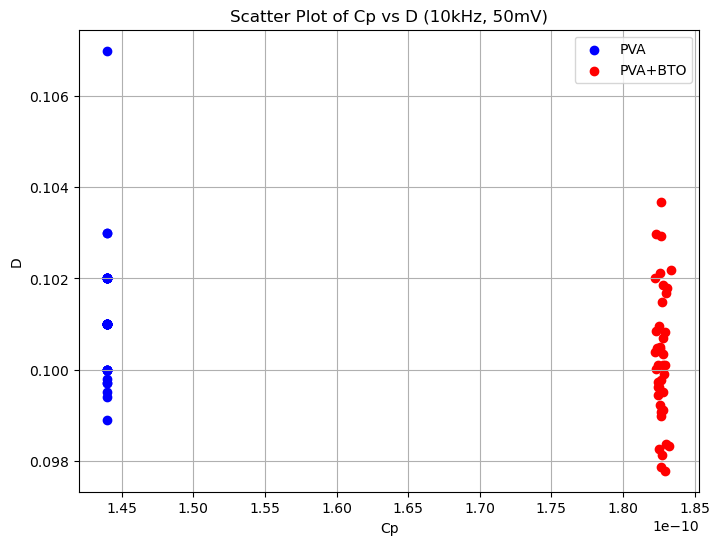

In [6]:
import matplotlib.pyplot as plt

# 각 클래스에서 Cp와 D 추출
pva_df = PVA[MaxPoint]
bto_df = BTO[MaxPoint]

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(pva_df['Cp [F]'], pva_df['D'], color='blue', label='PVA')
plt.scatter(bto_df['Cp [F]'], bto_df['D'], color='red', label='PVA+BTO')
plt.xlabel('Cp')
plt.ylabel('D')
plt.title('Scatter Plot of Cp vs D (10kHz, 50mV)')
plt.legend()
plt.grid(True)
plt.show()


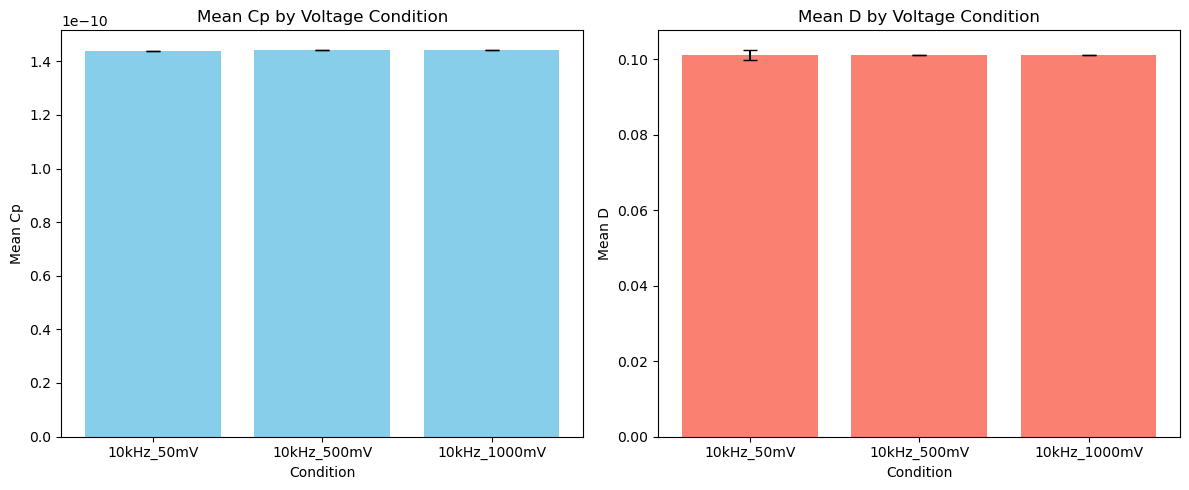

In [11]:
import matplotlib.pyplot as plt

# 실험 조건 라벨
labels = ['10kHz_50mV', '10kHz_500mV', '10kHz_1000mV']

# Cp, D 평균과 표준편차 계산
cp_means = [df['Cp [F]'].mean() for df in PVA[:3]]
cp_stds = [df['Cp [F]'].std() for df in PVA[:3]]
d_means = [df['D'].mean() for df in PVA[:3]]
d_stds = [df['D'].std() for df in PVA[:3]]

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Cp 평균 바 그래프
axes[0].bar(labels, cp_means, yerr=cp_stds, capsize=5, color='skyblue')
axes[0].set_title('Mean Cp by Voltage Condition')
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Mean Cp')

# D 평균 바 그래프
axes[1].bar(labels, d_means, yerr=d_stds, capsize=5, color='salmon')
axes[1].set_title('Mean D by Voltage Condition')
axes[1].set_xlabel('Condition')
axes[1].set_ylabel('Mean D')

plt.tight_layout()
plt.show()
